<a href="https://colab.research.google.com/github/vedantghodki01/Feature-AB-Test-Analysis/blob/main/Feature_AB_Testing_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Correct file name
df = pd.read_csv('/AB_Test_Results.csv')
print(df.head())
print(df.info())
print(df.columns.tolist())




   USER_ID VARIANT_NAME  REVENUE
0      737      variant      0.0
1     2423      control      0.0
2     9411      control      0.0
3     7311      control      0.0
4     6174      variant      0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB
None
['USER_ID', 'VARIANT_NAME', 'REVENUE']


In [ ]:
# Create binary flag using correct column name
df['converted'] = (df['REVENUE'] > 0).astype(int)

# Display updated columns to confirm
print(df[['VARIANT_NAME', 'REVENUE', 'converted']].head())



  VARIANT_NAME  REVENUE  converted
0      variant      0.0          0
1      control      0.0          0
2      control      0.0          0
3      control      0.0          0
4      variant      0.0          0


In [ ]:
import sqlite3

conn = sqlite3.connect('ab_project.db')  # Create or connect to database
df.to_sql('ab_data', conn, if_exists='replace', index=False)

# Quick verification
import pandas as pd
count = pd.read_sql_query('SELECT COUNT(*) AS cnt FROM ab_data', conn)
print("Rows in database:", count['cnt'][0])


Rows in database: 10000


In [ ]:
summary = pd.read_sql_query("""
    SELECT
      VARIANT_NAME AS group_label,
      COUNT(*) AS num_users,
      AVG(REVENUE) AS avg_revenue,
      AVG(converted) AS conv_rate
    FROM ab_data
    GROUP BY VARIANT_NAME;
""", conn)

print(summary)


  group_label  num_users  avg_revenue  conv_rate
0     control       4984     0.129013   0.016051
1     variant       5016     0.070070   0.014354


In [ ]:
from scipy import stats

df_sql = pd.read_sql_query("SELECT VARIANT_NAME, REVENUE, converted FROM ab_data", conn)
a = df_sql[df_sql.VARIANT_NAME == 'A']
b = df_sql[df_sql.VARIANT_NAME == 'B']

# Revenue comparison
tstat, pval = stats.ttest_ind(a.REVENUE, b.REVENUE, equal_var=False)
print(f"Revenue T-statistic: {tstat:.3f}, P-value: {pval:.4f}")

# Conversion rate comparison using chi-square
from scipy import stats as st
contingency = pd.crosstab(df_sql.VARIANT_NAME, df_sql.converted)
chi2, p2, _, _ = st.chi2_contingency(contingency)
print(f"Conversion chi-square: {chi2:.3f}, P-value: {p2:.4f}")



Revenue T-statistic: nan, P-value: nan
Conversion chi-square: 0.374, P-value: 0.5406


/usr/local/lib/python3.11/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


In [ ]:
seg_buckets = pd.read_sql_query("""
  SELECT
    VARIANT_NAME AS group_label,
    CASE
      WHEN REVENUE = 0 THEN 'no_revenue'
      WHEN REVENUE BETWEEN 1 AND 50 THEN 'low'
      WHEN REVENUE BETWEEN 51 AND 200 THEN 'medium'
      ELSE 'high'
    END AS revenue_segment,
    COUNT(*) AS users,
    AVG(converted) AS conv_rate,
    AVG(REVENUE) AS avg_revenue
  FROM ab_data
  GROUP BY group_label, revenue_segment
  ORDER BY group_label, revenue_segment;
""", conn)

print(seg_buckets)


  group_label revenue_segment  users  conv_rate  avg_revenue
0     control            high      9        1.0     0.310000
1     control             low     70        1.0     6.345714
2     control          medium      1        1.0   196.010000
3     control      no_revenue   4904        0.0     0.000000
4     variant            high     11        1.0     0.383636
5     variant             low     59        1.0     3.917966
6     variant          medium      2        1.0    58.045000
7     variant      no_revenue   4944        0.0     0.000000


In [ ]:
seg_conv = pd.read_sql_query("""
  SELECT
    VARIANT_NAME AS group_label,
    converted,
    COUNT(*) AS n_users,
    AVG(REVENUE) AS avg_revenue
  FROM ab_data
  GROUP BY group_label, converted;
""", conn)

print(seg_conv)


  group_label  converted  n_users  avg_revenue
0     control          0     4904     0.000000
1     control          1       80     8.037500
2     variant          0     4944     0.000000
3     variant          1       72     4.881528


<ipython-input-20-2250829899>:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=summary, x='group_label', y='avg_revenue',


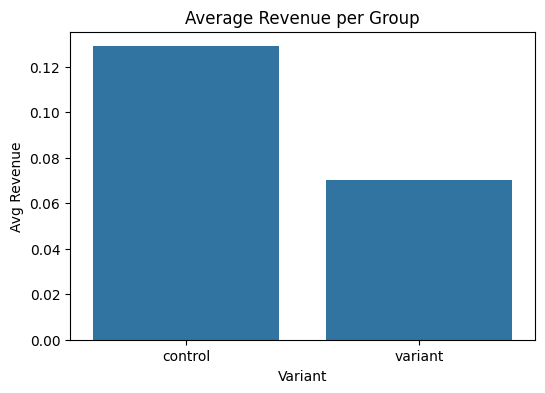

<ipython-input-20-2250829899>:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=summary, x='group_label', y='conv_rate',


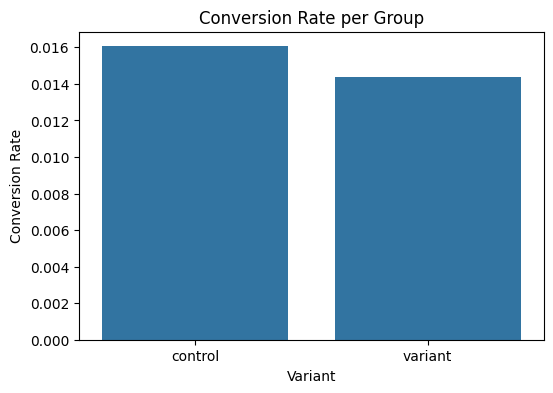

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare summary data
summary = pd.read_sql_query("""
  SELECT VARIANT_NAME AS group_label,
         AVG(REVENUE) AS avg_revenue,
         AVG(converted) AS conv_rate
  FROM ab_data
  GROUP BY VARIANT_NAME;
""", conn)

# Revenue bar plot
plt.figure(figsize=(6,4))
sns.barplot(data=summary, x='group_label', y='avg_revenue',
            estimator='mean', ci=95)
plt.title('Average Revenue per Group')
plt.ylabel('Avg Revenue')
plt.xlabel('Variant')
plt.show()

# Conversion rate bar plot
plt.figure(figsize=(6,4))
sns.barplot(data=summary, x='group_label', y='conv_rate',
            estimator='mean', ci=95)
plt.title('Conversion Rate per Group')
plt.ylabel('Conversion Rate')
plt.xlabel('Variant')
plt.show()


In [ ]:
print(seg_buckets[['revenue_segment', 'conv_rate', 'users']])

  revenue_segment  conv_rate  users
0            high        1.0      9
1             low        1.0     70
2          medium        1.0      1
3      no_revenue        0.0   4904
4            high        1.0     11
5             low        1.0     59
6          medium        1.0      2
7      no_revenue        0.0   4944


<Axes: xlabel='revenue_segment', ylabel='conv_rate'>

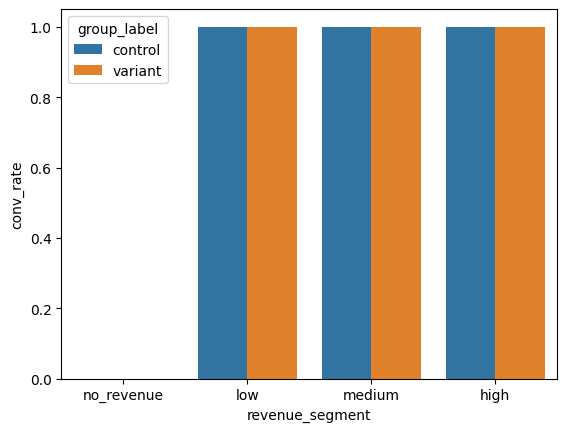

In [ ]:
order = ['no_revenue', 'low', 'medium', 'high']
sns.barplot(data=seg_buckets, x='revenue_segment', y='conv_rate',
            hue='group_label', order=order, errorbar=None)


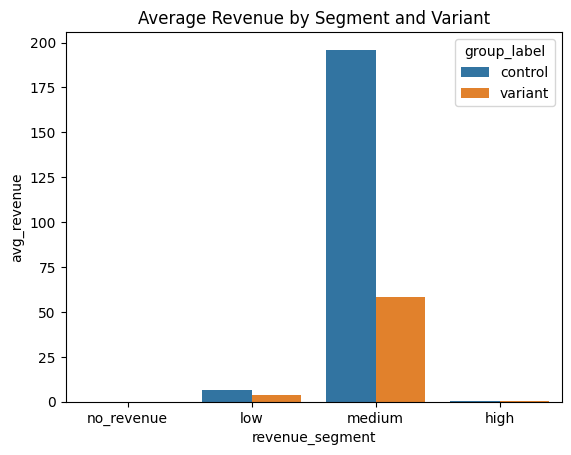

In [ ]:
sns.barplot(data=seg_buckets, x='revenue_segment', y='avg_revenue',
            hue='group_label', order=order, errorbar=None)
plt.title('Average Revenue by Segment and Variant')
plt.show()


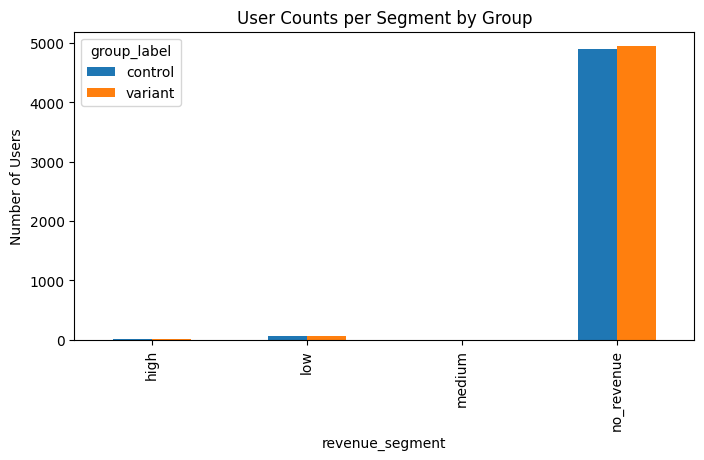

In [ ]:
import matplotlib.pyplot as plt

# Create a pivoted count table
count_pivot = seg_buckets.pivot(index='revenue_segment', columns='group_label', values='users')
count_pivot.plot(kind='bar', figsize=(8,4))
plt.title('User Counts per Segment by Group')
plt.ylabel('Number of Users')
plt.show()
